# Bayesian Network Classifier for Diabetes

## Author: Karishma Lakhoo (2153211)




In [92]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, ExhaustiveSearch, BayesianEstimator, MaximumLikelihoodEstimator
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score, f1_score, accuracy_score
from pgmpy.inference import VariableElimination
from scipy.stats import norm



# Load the dataset

In [93]:
df = pd.read_csv('diabetes_data_upload.csv')
df = df.sample(n=520, random_state=50)
# df.shape
df.head()


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
23,48,Male,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,No,Positive
399,64,Male,No,No,No,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes,Yes,No,Negative
393,51,Female,No,No,No,No,No,Yes,No,Yes,No,Yes,No,No,Yes,No,Negative
236,60,Male,No,No,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,No,Negative
102,90,Female,No,Yes,Yes,No,No,Yes,Yes,Yes,No,No,No,Yes,Yes,No,Positive


# Analysing and preprocessing the data
identify missing data in the dataset

In [94]:
print(np.sum(pd.isnull(df), axis=0))


Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64


# Convert categorical variables to numeric values

In [95]:
# Initialize a LabelEncoder
le = LabelEncoder()
categories = {}

# Convert categorical variables to numeric using label encoding
categorical_vars = ['Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
                    'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
                    'Itching', 'Irritability', 'delayed healing', 'partial paresis',
                    'muscle stiffness', 'Alopecia', 'Obesity', 'class']

for var in categorical_vars:
    categories[var] = dict(zip(le.fit_transform(df[var].unique()), df[var].unique()))
    df[var] = le.fit_transform(df[var])


# Discretize continuous variables

In [96]:
ages = df['Age'].values
bins = [10, 25, 40, 55, 70, 85, np.Inf]
labels = ['10-25', '25-40', '40-55', '55-70', '70-85', '85+']
categorical_ages = pd.cut(ages , bins=  bins, labels=labels, include_lowest=True)
df['Age'] = categorical_ages
categories['Age'] = dict(zip(le.fit_transform(categorical_ages.unique()), categorical_ages.unique()))
df['Age'] = le.fit_transform(df['Age'])

In [97]:
df.head()
print(categories)


{'Gender': {1: 'Male', 0: 'Female'}, 'Polyuria': {0: 'No', 1: 'Yes'}, 'Polydipsia': {1: 'Yes', 0: 'No'}, 'sudden weight loss': {1: 'Yes', 0: 'No'}, 'weakness': {1: 'Yes', 0: 'No'}, 'Polyphagia': {0: 'No', 1: 'Yes'}, 'Genital thrush': {0: 'No', 1: 'Yes'}, 'visual blurring': {1: 'Yes', 0: 'No'}, 'Itching': {1: 'Yes', 0: 'No'}, 'Irritability': {1: 'Yes', 0: 'No'}, 'delayed healing': {1: 'Yes', 0: 'No'}, 'partial paresis': {0: 'No', 1: 'Yes'}, 'muscle stiffness': {0: 'No', 1: 'Yes'}, 'Alopecia': {0: 'No', 1: 'Yes'}, 'Obesity': {0: 'No', 1: 'Yes'}, 'class': {1: 'Positive', 0: 'Negative'}, 'Age': {2: '40-55', 3: '55-70', 5: '85+', 4: '70-85', 1: '25-40', 0: '10-25'}}


In [98]:
for col in list(df.columns):
    print(col, set(df[col]))


Age {0, 1, 2, 3, 4, 5}
Gender {0, 1}
Polyuria {0, 1}
Polydipsia {0, 1}
sudden weight loss {0, 1}
weakness {0, 1}
Polyphagia {0, 1}
Genital thrush {0, 1}
visual blurring {0, 1}
Itching {0, 1}
Irritability {0, 1}
delayed healing {0, 1}
partial paresis {0, 1}
muscle stiffness {0, 1}
Alopecia {0, 1}
Obesity {0, 1}
class {0, 1}


# Splitting data into train, test and validation data

In [99]:
train_data, temp_data = train_test_split(df, test_size=0.2, random_state=50)
test_data, val_data = train_test_split(temp_data, test_size=0.5, random_state=50)
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(416, 17)
(52, 17)
(52, 17)


# Identify relations between different features using a correlation map

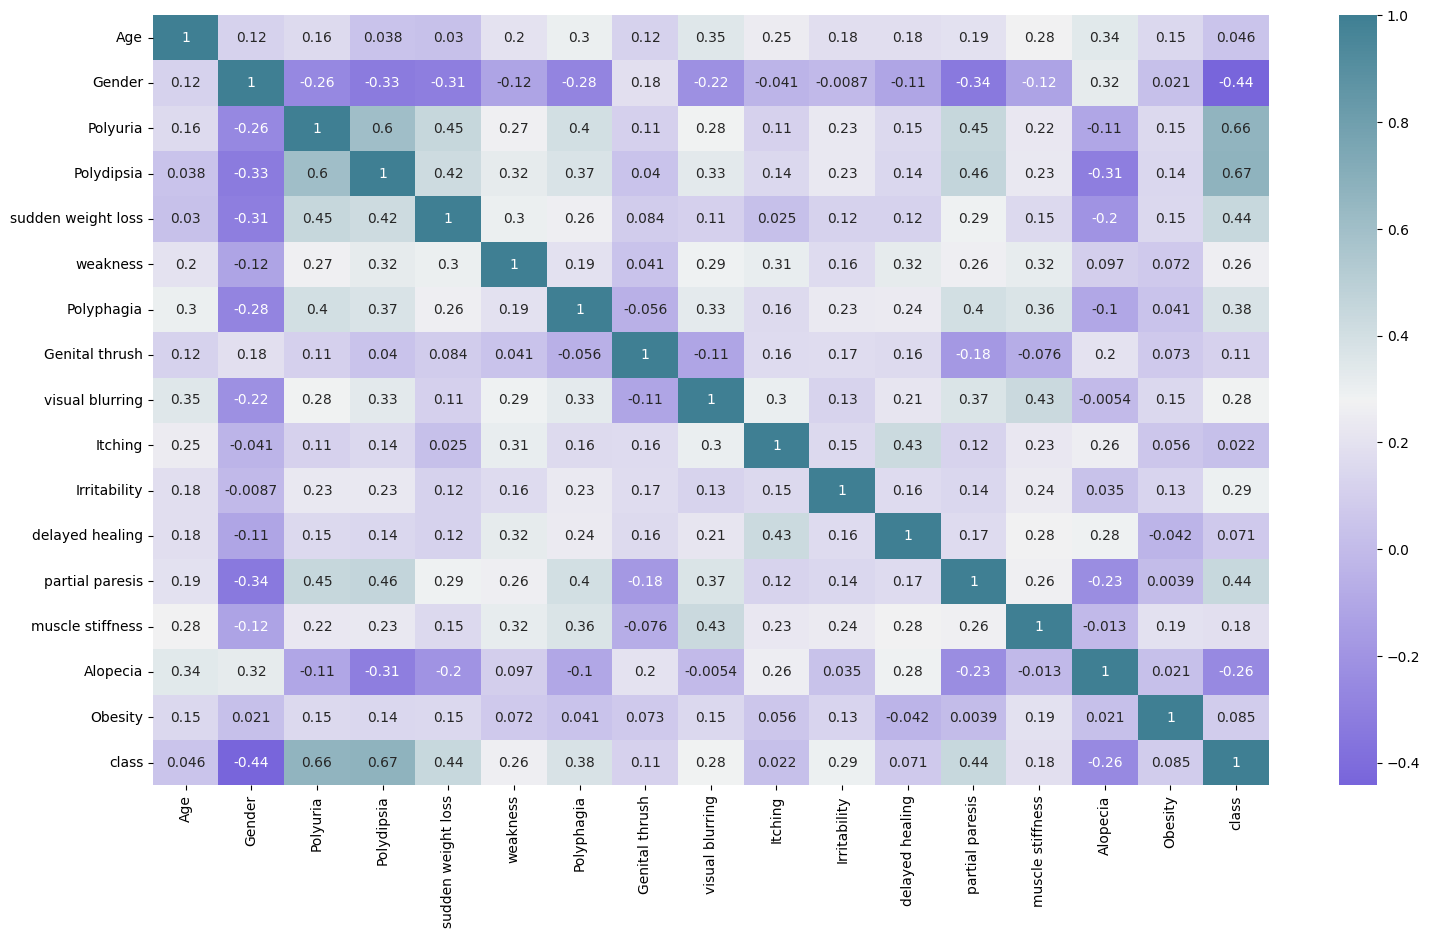

In [100]:
corr = train_data.corr()
plt.figure(figsize=(18,10))
cmap = sns.diverging_palette(270, 220, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap)
plt.show()


from the correlation map, we can see the following strong relations between features and between features and the class target feature:
1. Polyuria and Polydipsia
2. Polydipsia and class
3. Polyuria and class
4. sudden weight loss and class
5. Polydipsia and sudden weight loss
6. Polyuria and sudden weight loss
7. partial paresis and class
8. Polyphagia and class
9. visual blurring and class
10. weakeness and class
11. partial paresis and weakness
12. partial paresis and visual blurring





# Creating a custom BN using empirical and domain knowledge


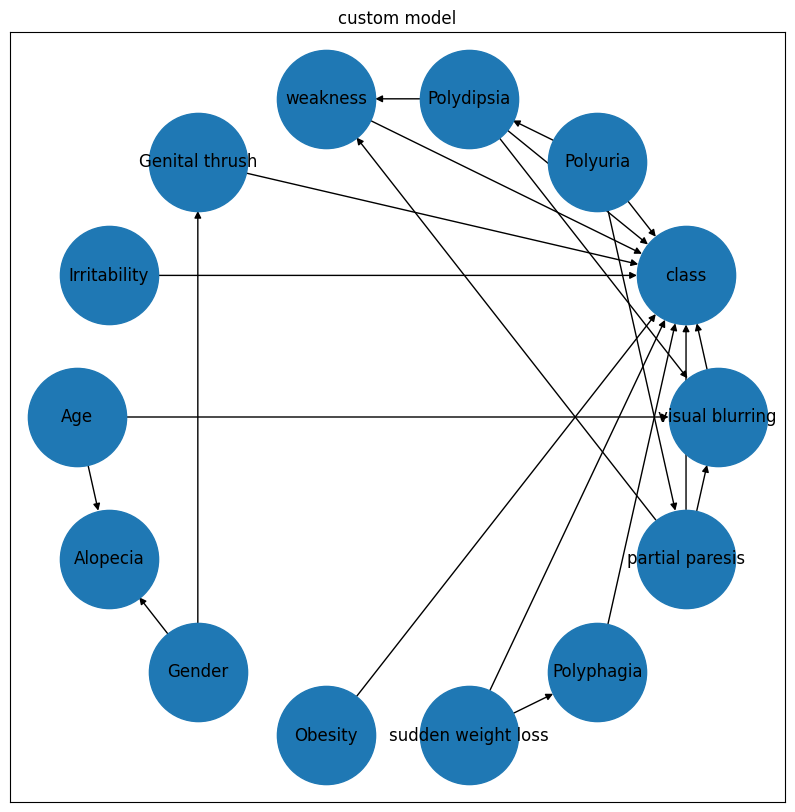

In [101]:
custom_model = BayesianNetwork([('visual blurring', 'class'),
                                ('Polyuria', 'class'),
                                ('Polyuria', 'Polydipsia'),
                                ('Polydipsia', 'visual blurring'),
                                ('Polydipsia', 'weakness'),
                                ('Polydipsia', 'class'),
                                ('Genital thrush', 'class'),
                                ('Irritability', 'class'),
                                ('Age', 'Alopecia'),
                                ('Age', 'visual blurring'),
                                ('Gender', 'Alopecia'),
                                ('Gender', 'Genital thrush'),
                                ('Obesity', 'class'),
                                ('sudden weight loss', 'class'),
                                ('sudden weight loss', 'Polyphagia'),
                                ('partial paresis', 'class'),
                                ('Polyuria', 'partial paresis'),
                                ('weakness', 'class'),
                                ('Polyphagia', 'class'),
                                ('partial paresis', 'weakness'),
                                ('partial paresis', 'visual blurring')])
def plot_network(network: 'DAG', name: str = 'Network', save_image: bool = False):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    nx.draw_networkx(network, pos=nx.drawing.layout.circular_layout(network), ax=ax, node_size=5000)
    ax.set_title(name)
    if save_image:
        fig.savefig(name)
    plt.show()

plot_network(custom_model, "custom model")

# Using structured learning methods to create BNs


In [102]:
networks = {} # Dictionary to store the network structure for each scoring method

for i in ['k2score', 'bdeuscore', 'bdsscore', 'bicscore', 'aicscore']:
    network = HillClimbSearch(train_data, use_cache=False).estimate(scoring_method=i, max_indegree=1)
    networks[i] = network    
    model = BayesianNetwork(network)


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

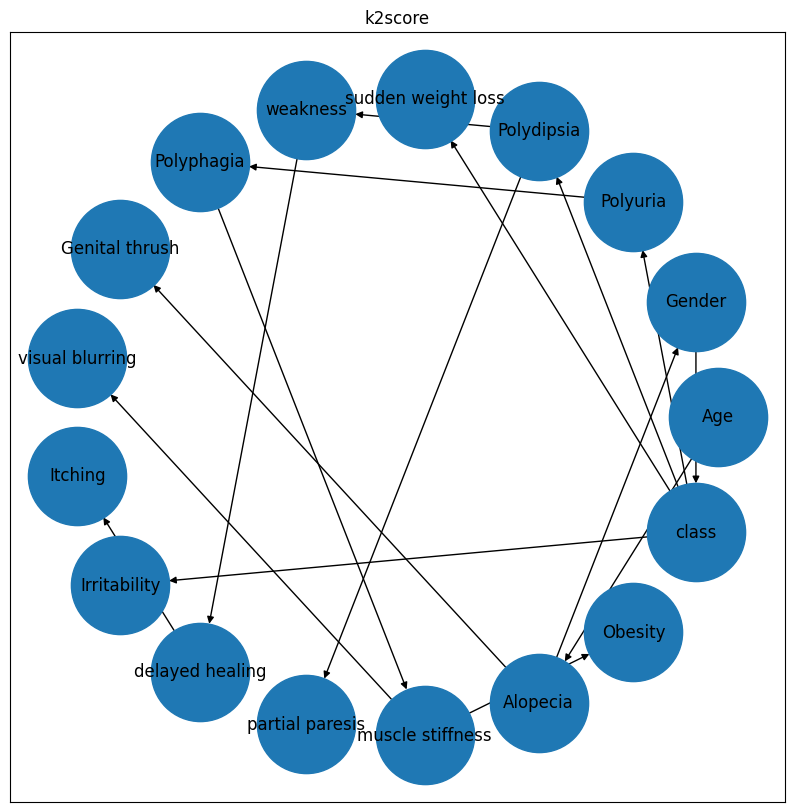

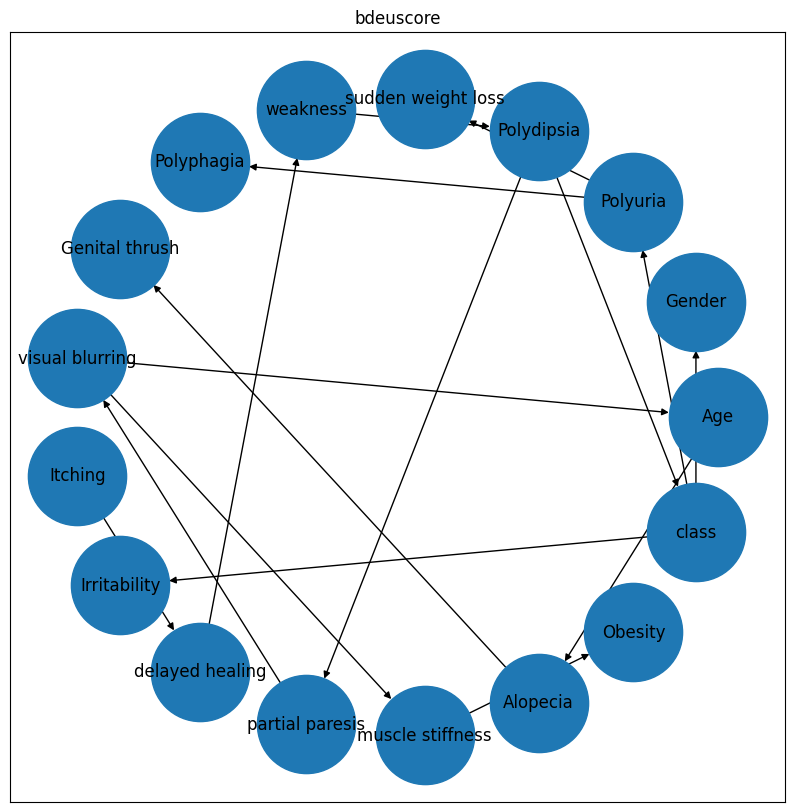

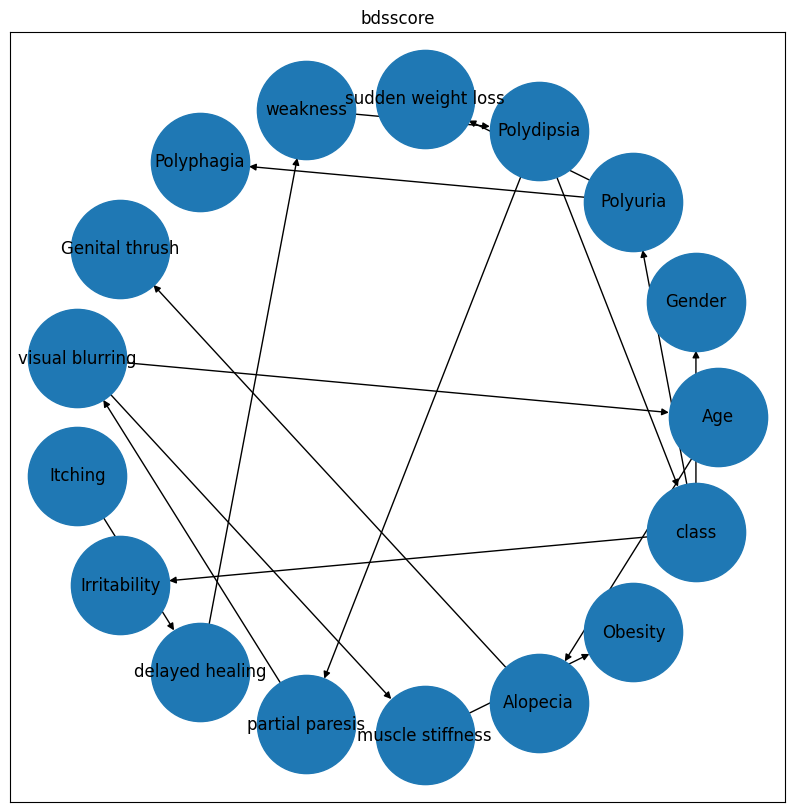

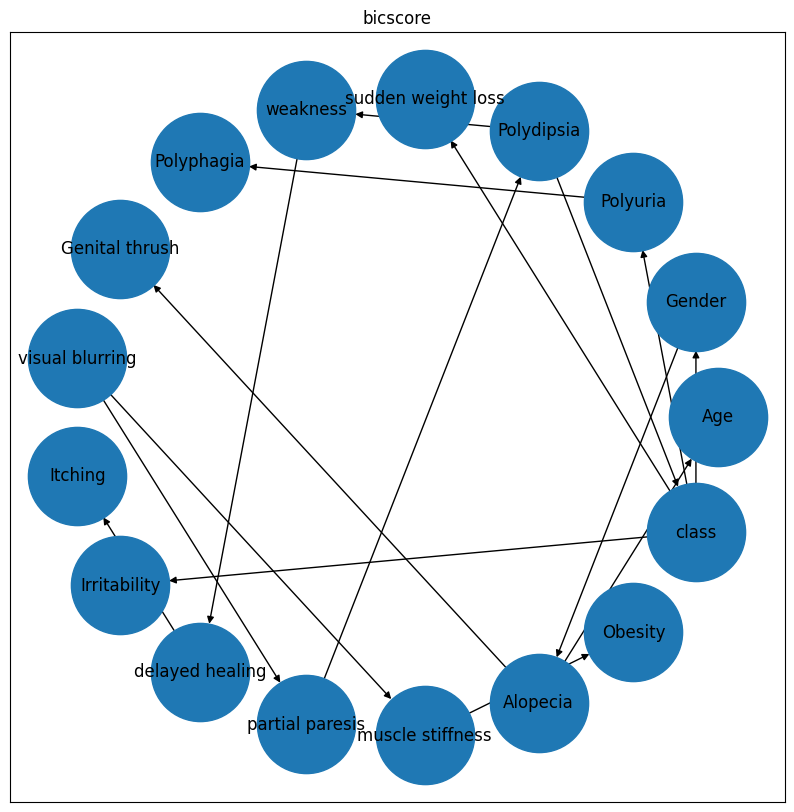

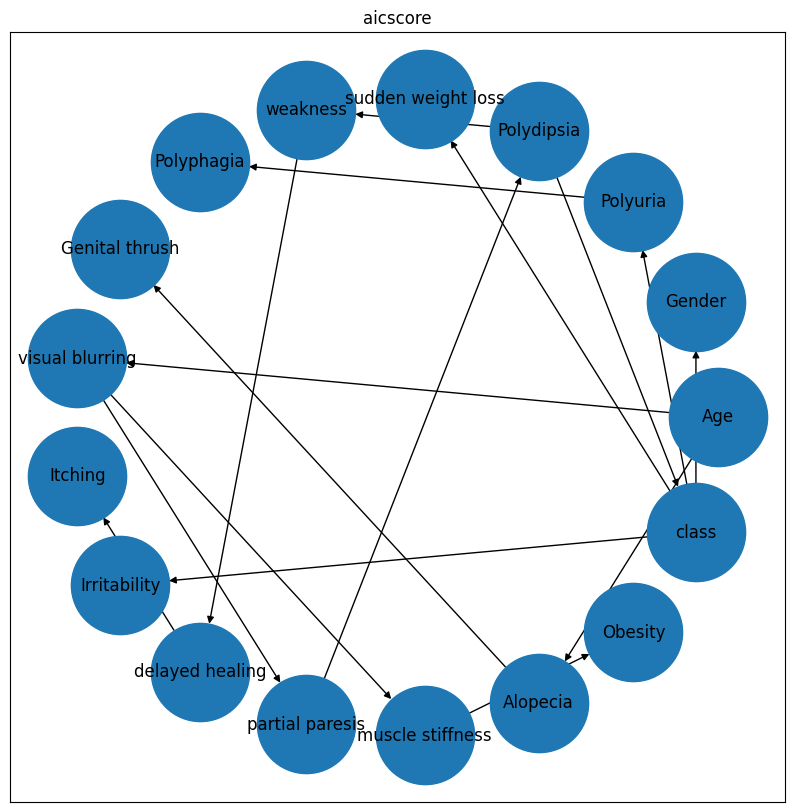

In [103]:
# Plot each Bayesian network
for scoring_method, network in networks.items():
    plot_network(network, scoring_method)

# Using bicscore

  0%|          | 0/1000000 [00:00<?, ?it/s]

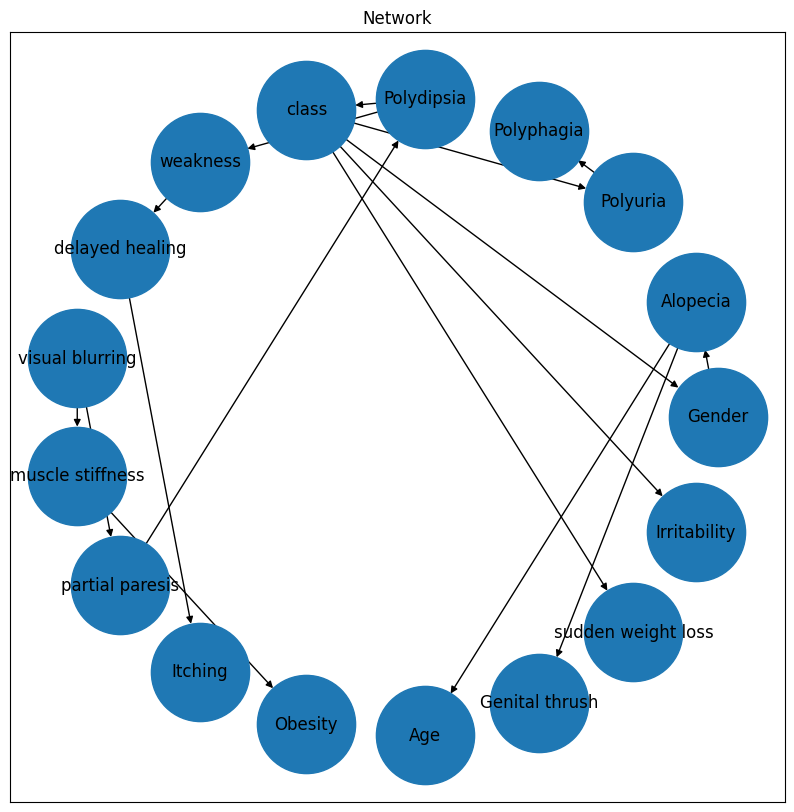

In [104]:
bic = BicScore(data=train_data)
hc = HillClimbSearch(data=train_data)
learnt_BN = hc.estimate(scoring_method=bic, max_indegree = 1)
learnt_BN = BayesianNetwork(learnt_BN.edges())
plot_network(learnt_BN)

# Constrained Hill Climb
Blacklisting edges that are unexplainable


[('class', 'Age'), ('class', 'Gender'), ('class', 'Polyuria'), ('class', 'Polydipsia'), ('class', 'sudden weight loss'), ('class', 'weakness'), ('class', 'Polyphagia'), ('class', 'Genital thrush'), ('class', 'visual blurring'), ('class', 'Itching'), ('class', 'Irritability'), ('class', 'delayed healing'), ('class', 'partial paresis'), ('class', 'muscle stiffness'), ('class', 'Alopecia'), ('class', 'Obesity'), ('Age', 'Age'), ('Gender', 'Age'), ('Polyuria', 'Age'), ('Polydipsia', 'Age'), ('sudden weight loss', 'Age'), ('weakness', 'Age'), ('Polyphagia', 'Age'), ('Genital thrush', 'Age'), ('visual blurring', 'Age'), ('Itching', 'Age'), ('Irritability', 'Age'), ('delayed healing', 'Age'), ('partial paresis', 'Age'), ('muscle stiffness', 'Age'), ('Alopecia', 'Age'), ('Obesity', 'Age'), ('class', 'Age'), ('Age', 'Gender'), ('Gender', 'Gender'), ('Polyuria', 'Gender'), ('Polydipsia', 'Gender'), ('sudden weight loss', 'Gender'), ('weakness', 'Gender'), ('Polyphagia', 'Gender'), ('Genital thru

  0%|          | 0/1000000 [00:00<?, ?it/s]

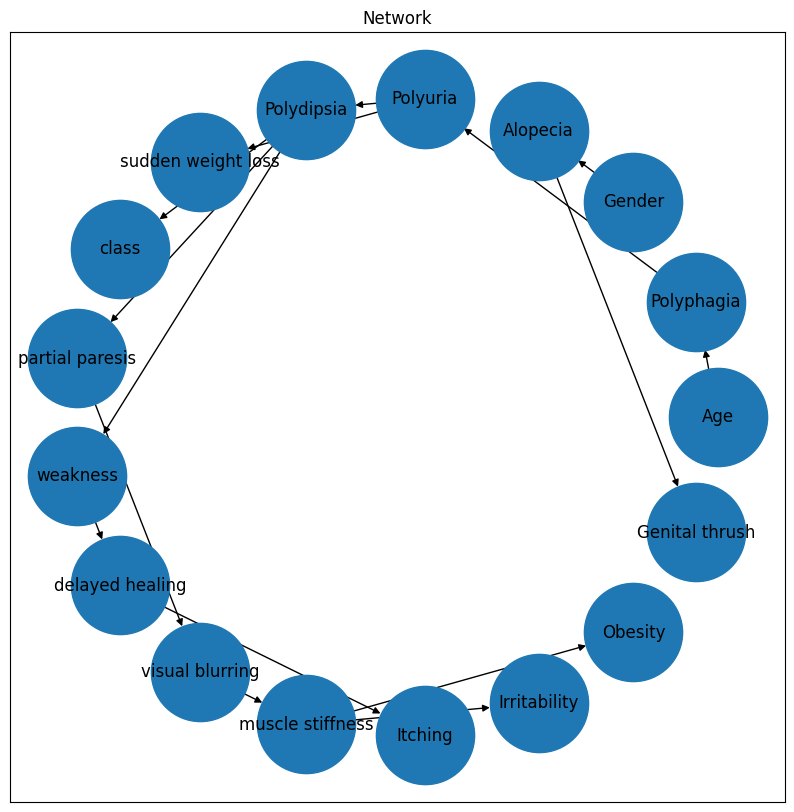

In [105]:
blacklisted = [("class",i) for i in df.columns if i != 'class']
blacklisted.extend([(i, 'Age') for i in df.columns if i != 'age'])
blacklisted.extend([(i, 'Gender') for i in df.columns if i != 'gender'])
blacklisted.extend([('sudden weight loss', 'Obesity')])
print(blacklisted)
learnt_BN_blacklisted = hc.estimate(scoring_method=bic, black_list=blacklisted, max_indegree = 1)
learnt_BN_blacklisted = BayesianNetwork(learnt_BN_blacklisted.edges())
plot_network(learnt_BN_blacklisted)


# Parameter Learning
Parameter estimation invloves learning the structure of the CPTs of the bayesian network. The pgmpy library offers a variety of estimates. Here we choose to use a Bayesian Estimater as opposed to the Maximum Likelihood Estimator due to its robustness. A Bayesian Dirichlet equivalent uniform prior (BDeu) is used with default setting applied. Here we are only displaying the CPDs for the custom model, however the same code can be applied to the other models to obtain their CPDs


In [106]:
custom_model.cpds = []
learnt_BN.cpds = []
learnt_BN_blacklisted.cpds = []

custom_model.fit(data=train_data,
          estimator=BayesianEstimator,
          prior_type="BDeu")
learnt_BN.fit(data=train_data,
          estimator=BayesianEstimator,
          prior_type="BDeu")
learnt_BN_blacklisted.fit(data=train_data,
          estimator=BayesianEstimator,
          prior_type="BDeu")

print(f'Check model: {custom_model.check_model()}\n')
for cpd in custom_model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')


Check model: True

CPT of visual blurring:
+--------------------+-----+--------------------+
| Age                | ... | Age(5)             |
+--------------------+-----+--------------------+
| Polydipsia         | ... | Polydipsia(1)      |
+--------------------+-----+--------------------+
| partial paresis    | ... | partial paresis(1) |
+--------------------+-----+--------------------+
| visual blurring(0) | ... | 0.5                |
+--------------------+-----+--------------------+
| visual blurring(1) | ... | 0.5                |
+--------------------+-----+--------------------+ 

CPT of class:
+--------------------+-----+-----------------------+
| Genital thrush     | ... | Genital thrush(1)     |
+--------------------+-----+-----------------------+
| Irritability       | ... | Irritability(1)       |
+--------------------+-----+-----------------------+
| Obesity            | ... | Obesity(1)            |
+--------------------+-----+-----------------------+
| Polydipsia        

# Inference
Implementing exact and approimate inference can provide insights into how these bayesian networks created can help diagonse diabetes.   
## Exact Inference
Exact inference on all models will be done using pgmpy's Variable Elimination method.

In [107]:
custom_model_features = list(custom_model.nodes())
custom_model_features.remove("class")

custom_categories = {feature: categories[feature] for feature in custom_model_features}

unconstrained_hc_features = list(learnt_BN.nodes())
unconstrained_hc_features.remove("class")

unconstrained_categories = {feature: categories[feature] for feature in unconstrained_hc_features}

constrained_hc_features = list(learnt_BN_blacklisted.nodes())
constrained_hc_features.remove("class")

constrained_categories = {feature: categories[feature] for feature in constrained_hc_features}


print("CUSTOM MODEL")
print()
custom_infer = VariableElimination(custom_model)
for feature, subcategories in custom_categories.items():
    print(f"Probability of diabetes given {feature}")
    print()

    for subcategory_value, subcategory_label in subcategories.items():
        evidence = {feature: subcategory_value}
        query_result = custom_infer.query(['class'], evidence=evidence)
        print(f"Probability of diabetes given {feature} = {subcategory_label}:")
        print(query_result)
    print("---")


print("UNCONSTRAINED MODEL")
print()
unconstrained_infer = VariableElimination(learnt_BN)
for feature, subcategories in unconstrained_categories.items():
    print(f"Probability of diabetes given {feature}")
    print()

    for subcategory_value, subcategory_label in subcategories.items():
        evidence = {feature: subcategory_value}
        query_result = unconstrained_infer.query(['class'], evidence=evidence)
        print(f"Probability of diabetes given {feature} = {subcategory_label}:")
        print(query_result)
    print("---")

print("CONSTRAINED MODEL")
print()
constrained_infer = VariableElimination(learnt_BN_blacklisted)
for feature, subcategories in constrained_categories.items():
    print(f"Probability of diabetes given {feature}")
    print()

    for subcategory_value, subcategory_label in subcategories.items():
        evidence = {feature: subcategory_value}
        query_result = constrained_infer.query(['class'], evidence=evidence)
        print(f"Probability of diabetes given {feature} = {subcategory_label}:")
        print(query_result)
    print("---")    


CUSTOM MODEL

Probability of diabetes given visual blurring

Probability of diabetes given visual blurring = Yes:
+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.3823 |
+----------+--------------+
| class(1) |       0.6177 |
+----------+--------------+
Probability of diabetes given visual blurring = No:
+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.5142 |
+----------+--------------+
| class(1) |       0.4858 |
+----------+--------------+
---
Probability of diabetes given Polyuria

Probability of diabetes given Polyuria = No:
+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.5859 |
+----------+--------------+
| class(1) |       0.4141 |
+----------+--------------+
Probability of diabetes given Polyuria = Yes:
+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.3200 |

# Bias in models
We'll examine how various models (custom model, unconstrained hill climb model, and constrained hill climb model) interpret different inquiries. Specifically, we'll focus on the following conditional probabilities:

Probability of diabetes given a specific feature.
Probability of diabetes given vision blurring.
These inquiries aim to:
Investigate whether the structures of the networks imply bias, such as whether a feature influences the likelihood of diabetes.

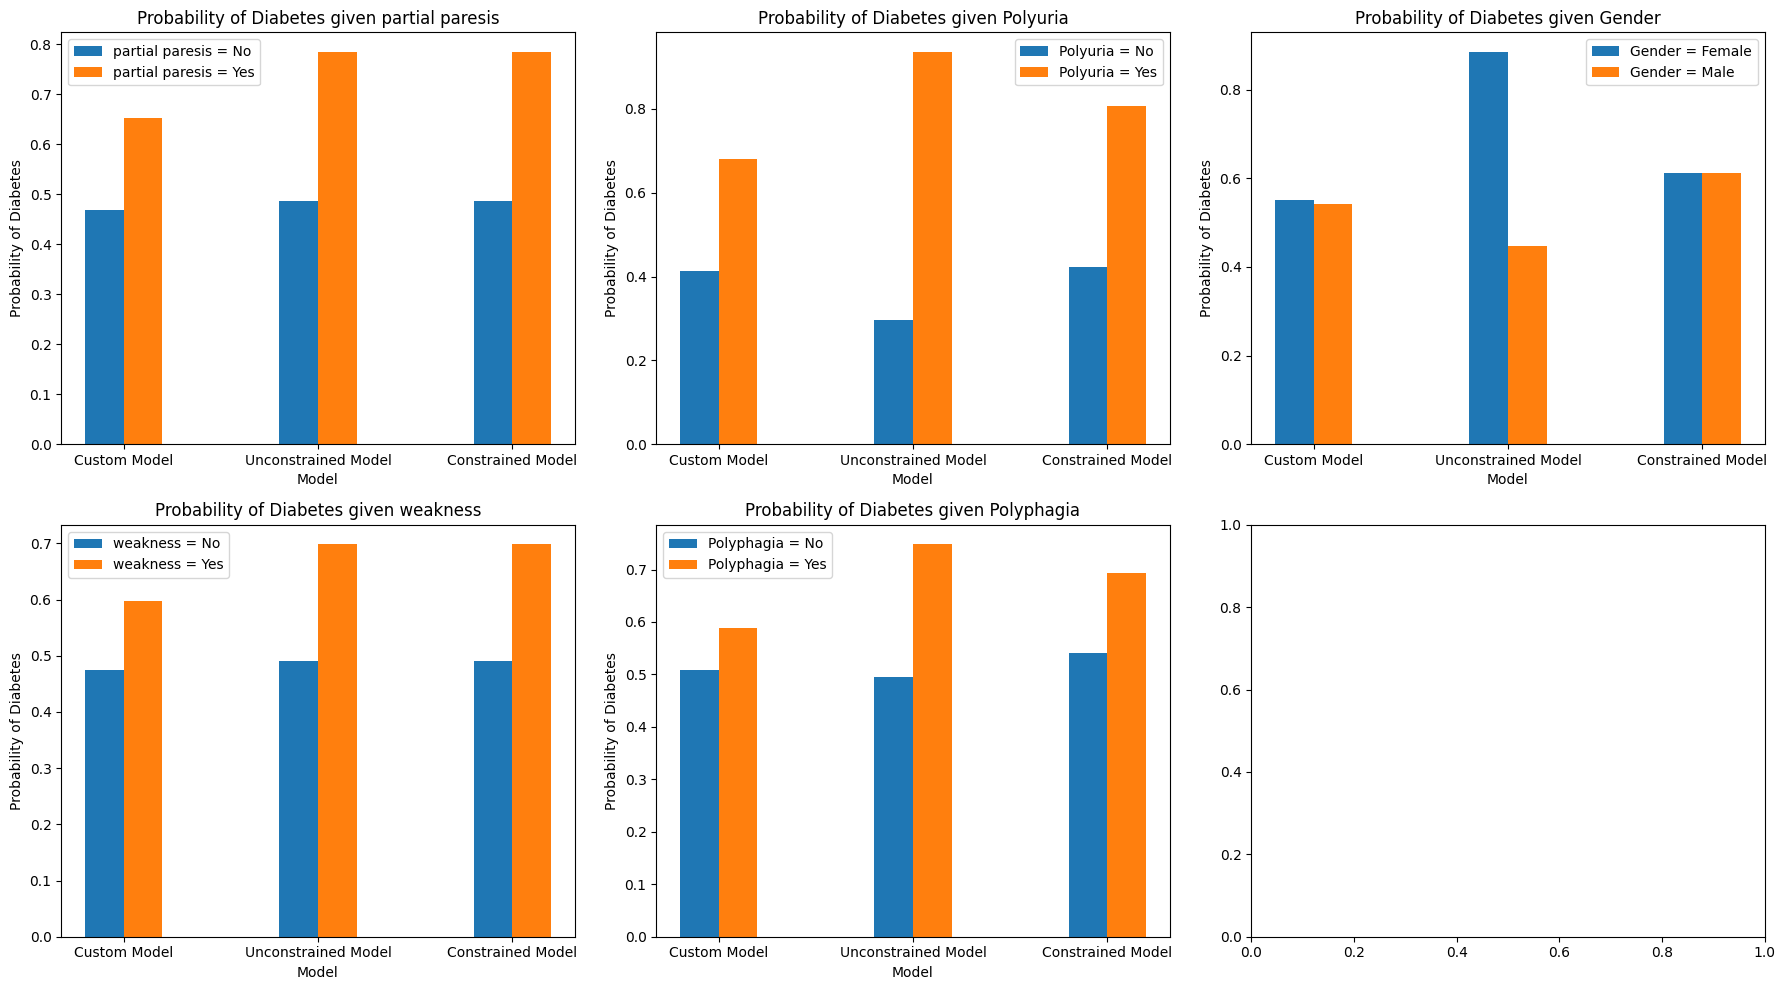

In [108]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cpds(feature, models, inferences, categories, ax):
    width = 0.2
    x = np.arange(len(models))

    # Sort the subcategories alphabetically
    sorted_subcategories = sorted(categories[feature].items(), key=lambda x: x[1])

    for i, (subcategory_value, subcategory_label) in enumerate(sorted_subcategories):
        probabilities = []
        for model, inference in zip(models, inferences):
            if feature in model.nodes():
                evidence = {feature: subcategory_value}
                query_result = inference.query(['class'], evidence=evidence)
                probabilities.append(query_result.values[1])  # Probability of class = 1 (diabetes)
            else:
                probabilities.append(0)  # If feature not in model, set probability to 0

        ax.bar(x + i * width, probabilities, width, label=f"{feature} = {subcategory_label}")

    ax.set_xlabel("Model")
    ax.set_ylabel(f"Probability of Diabetes")
    ax.set_title(f"Probability of Diabetes given {feature}")
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(["Custom Model", "Unconstrained Model", "Constrained Model"])
    ax.legend()


models2 = [custom_model, learnt_BN, learnt_BN_blacklisted]
inferences = [custom_infer, unconstrained_infer, constrained_infer]
features = ['partial paresis', 'Polyuria', 'Gender', 'weakness', 'Polyphagia']

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for idx, feature in enumerate(features):
    row = idx // 3
    col = idx % 3
    plot_cpds(feature, models2, inferences, custom_categories, axs[row, col])

plt.tight_layout()
plt.show()


# Classification

In [109]:
models = {
    'Custom Model': custom_model,
    'Unconstrained Hill Climb Model': learnt_BN,
    'Constrained Hill Climb Model': learnt_BN_blacklisted
}

def predict(data_point: dict, inference_object: VariableElimination, query: str, model_features: list) -> tuple[float, float]:
    evidence = {k: v for k, v in data_point.items() if k in model_features and k != 'class'}
    result = inference_object.query(variables=['class'], evidence=evidence)
    values = result.state_names[query]
    diabetes = np.argmax(result.values)
    return diabetes, result.values

def predict_batch(batch: pd.DataFrame, inference_object: VariableElimination, query: str, model_features: list) -> list[int]:
    return [predict(data_point[1], inference_object, query, model_features)[0] for data_point in batch.iterrows()]

metrics = {model_name: None for model_name in models}
metricsVal = {model_name: None for model_name in models}
for model_name in metrics:
    model_features = models[model_name].nodes()
    preds = predict_batch(test_data, VariableElimination(models[model_name]), query='class', model_features=model_features)
    predsVal = predict_batch(val_data, VariableElimination(models[model_name]), query='class', model_features=model_features)
    metrics[model_name] = {
        'accuracy': accuracy_score(test_data['class'], preds),
        'precision': precision_score(test_data['class'], preds, average='weighted', zero_division=1),                
        'recall': recall_score(test_data['class'], preds),
        'f1_score': f1_score(test_data['class'], preds)
    }
    metricsVal[model_name] = {
        'accuracy': accuracy_score(val_data['class'], predsVal),
        'precision': precision_score(test_data['class'], preds, average='weighted', zero_division=1),      
        'recall': recall_score(val_data['class'], predsVal),
        'f1_score': f1_score(val_data['class'], predsVal)
    }
  
    print(f"Model: {model_name}")
    print()
    print("Test data")
    for metric, value in metrics[model_name].items():
        print(f'{metric}: {value:.2%}')
    print()
    print("Validation data")
    for metric, value in metricsVal[model_name].items():
        print(f'{metric}: {value:.2%}')
    print()

Model: Custom Model

Test data
accuracy: 92.31%
recall: 87.10%
precision: 93.54%
f1_score: 93.10%

Validation data
accuracy: 88.46%
precision: 93.54%
recall: 82.35%
f1_score: 90.32%

Model: Unconstrained Hill Climb Model

Test data
accuracy: 90.38%
recall: 90.32%
precision: 90.52%
f1_score: 91.80%

Validation data
accuracy: 80.77%
precision: 90.52%
recall: 82.35%
f1_score: 84.85%

Model: Constrained Hill Climb Model

Test data
accuracy: 80.77%
recall: 74.19%
precision: 83.26%
f1_score: 82.14%

Validation data
accuracy: 73.08%
precision: 83.26%
recall: 67.65%
f1_score: 76.67%


# Hyperparameter tuning

In [110]:
from sklearn.model_selection import ParameterGrid

# Define the range of max_indegree values to test
max_indegree_values = [1,2,3,4,5,6]

# Create a parameter grid
param_grid = {'max_indegree': max_indegree_values}

# Initialize dictionaries to store the best max_indegree and accuracy for each model type
best_max_indegree = {
    'learnt_BN': None,
    'learnt_BN_blacklisted': None
}
best_accuracy = {model_type: 0 for model_type in best_max_indegree}

# Perform grid search for learnt_BN and learnt_BN_blacklisted models
for model_type in ['learnt_BN', 'learnt_BN_blacklisted']:
    print(f"Hyperparameter tuning model type: {model_type}")
    
    for params in ParameterGrid(param_grid):
        max_indegree = params['max_indegree']
        
        if model_type == 'learnt_BN':
            # Learn the structure using Hill Climb Search with the current max_indegree
            hc = HillClimbSearch(data=train_data)
            learnt_BN = hc.estimate(max_indegree=max_indegree, scoring_method=bic)
            model = BayesianNetwork(learnt_BN.edges())
        else:
            # Learn the structure using Hill Climb Search with the current max_indegree and blacklisted edges
            learnt_BN_blacklisted = hc.estimate(max_indegree=max_indegree, scoring_method=bic, black_list=blacklisted)
            model = BayesianNetwork(learnt_BN_blacklisted.edges())
        
        # Fit the model with the training data
        model.fit(train_data, estimator=BayesianEstimator, prior_type="BDeu")
        
        # Perform validation and calculate accuracy
        model_features = model.nodes()
        preds_val = predict_batch(val_data, VariableElimination(model), query='class', model_features=model_features)
        accuracy = accuracy_score(val_data['class'], preds_val)
        
        print(f"Max indegree: {max_indegree}, Validation Accuracy: {accuracy:.4f}")
        
        # Update the best max_indegree and accuracy if the current model has a higher accuracy
        if accuracy > best_accuracy[model_type]:
            best_max_indegree[model_type] = max_indegree
            best_accuracy[model_type] = accuracy
    
    print(f"Best max_indegree for {model_type}: {best_max_indegree[model_type]}, Validation Accuracy: {best_accuracy[model_type]:.4f}")
    print()


# Print the best max_indegree for each model type
print("Best max_indegree values:")
for model_type, max_indegree in best_max_indegree.items():
    print(f"{model_type}: {max_indegree}")

Hyperparameter tuning model type: learnt_BN


  0%|          | 0/1000000 [00:00<?, ?it/s]

Max indegree: 1, Validation Accuracy: 0.8077


  0%|          | 0/1000000 [00:00<?, ?it/s]

Max indegree: 2, Validation Accuracy: 0.8462


  0%|          | 0/1000000 [00:00<?, ?it/s]

Max indegree: 3, Validation Accuracy: 0.9423


  0%|          | 0/1000000 [00:00<?, ?it/s]

Max indegree: 4, Validation Accuracy: 0.9423


  0%|          | 0/1000000 [00:00<?, ?it/s]

Max indegree: 5, Validation Accuracy: 0.9423


  0%|          | 0/1000000 [00:00<?, ?it/s]

Max indegree: 6, Validation Accuracy: 0.9423
Best max_indegree for learnt_BN: 3, Validation Accuracy: 0.9423

Hyperparameter tuning model type: learnt_BN_blacklisted


  0%|          | 0/1000000 [00:00<?, ?it/s]

Max indegree: 1, Validation Accuracy: 0.7308


  0%|          | 0/1000000 [00:00<?, ?it/s]

Max indegree: 2, Validation Accuracy: 0.8077


  0%|          | 0/1000000 [00:00<?, ?it/s]

Max indegree: 3, Validation Accuracy: 0.8654


  0%|          | 0/1000000 [00:00<?, ?it/s]

Max indegree: 4, Validation Accuracy: 0.8654


  0%|          | 0/1000000 [00:00<?, ?it/s]

Max indegree: 5, Validation Accuracy: 0.8654


  0%|          | 0/1000000 [00:00<?, ?it/s]

Max indegree: 6, Validation Accuracy: 0.8654
Best max_indegree for learnt_BN_blacklisted: 3, Validation Accuracy: 0.8654

Best max_indegree values:
learnt_BN: 3
learnt_BN_blacklisted: 3


In [112]:
# Define the best max_indegree values for each model type
best_max_indegree = {
    'custom': None,
    'learnt_BN': 2,  
    'learnt_BN_blacklisted': 3  
}

# Initialize dictionaries to store the models and metrics
models = {
    'custom': custom_model,
    'learnt_BN': None,
    'learnt_BN_blacklisted': None
}
metrics = {model_name: None for model_name in models}

# Learn the structure and fit the models using the best max_indegree values
for model_name in ['learnt_BN', 'learnt_BN_blacklisted']:
    if model_name == 'learnt_BN':
        hc = HillClimbSearch(data=train_data)
        learnt_BN = hc.estimate(max_indegree=best_max_indegree[model_name], scoring_method=bic)
        model = BayesianNetwork(learnt_BN.edges())
    else:
        learnt_BN_blacklisted = hc.estimate(max_indegree=best_max_indegree[model_name], scoring_method=bic, black_list=blacklisted)
        model = BayesianNetwork(learnt_BN_blacklisted.edges())
    
    model.fit(train_data, estimator=BayesianEstimator, prior_type="BDeu")
    models[model_name] = model

# Calculate metrics for each model using the test data
for model_name in metrics:
    model_features = models[model_name].nodes()
    preds = predict_batch(test_data, VariableElimination(models[model_name]), query='class', model_features=model_features)
    predsVal = predict_batch(val_data, VariableElimination(models[model_name]), query='class', model_features=model_features)


    metrics[model_name] = {
        'accuracy': accuracy_score(test_data['class'], preds),
        'precision': precision_score(test_data['class'], preds, average='weighted', zero_division=1),      
        'recall': recall_score(test_data['class'], preds),
        'f1_score': f1_score(test_data['class'], preds)
    }
    metricsVal[model_name] = {
        'accuracy': accuracy_score(val_data['class'], predsVal),
        'precision': precision_score(test_data['class'], preds, average='weighted', zero_division=1),      
        'recall': recall_score(val_data['class'], predsVal),
        'f1_score': f1_score(val_data['class'], predsVal)
    }

    if(model_name == 'custom'):
        temp_name = 'Custom Model'
    if(model_name == 'learnt_BN'):
        temp_name = 'Unconstrained Hill Climb Model'
    if(model_name == 'learnt_BN_blacklisted'):
        temp_name = 'Constrained Hill Climb Model'   
    
    print(f"Model: {temp_name}")
    print()
    print("Test data")
    for metric, value in metrics[model_name].items():
        print(f'{metric}: {value:.2%}')
    print()
    print("Validation data")
    for metric, value in metricsVal[model_name].items():
        print(f'{metric}: {value:.2%}')
    print()

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Model: Custom Model

Test data
accuracy: 92.31%
precision: 93.54%
recall: 87.10%
f1_score: 93.10%

Validation data
accuracy: 88.46%
precision: 93.54%
recall: 82.35%
f1_score: 90.32%

Model: Unconstrained Hill Climb Model

Test data
accuracy: 90.38%
precision: 90.74%
recall: 96.77%
f1_score: 92.31%

Validation data
accuracy: 84.62%
precision: 90.74%
recall: 91.18%
f1_score: 88.57%

Model: Constrained Hill Climb Model

Test data
accuracy: 88.46%
precision: 88.52%
recall: 93.55%
f1_score: 90.62%

Validation data
accuracy: 86.54%
precision: 88.52%
recall: 97.06%
f1_score: 90.41%


Considering the primary goal of maximizing predictive performance on unseen data (test data), the Unconstrained Hill Climb Model appears to be the better choice. Its higher accuracy and recall on the test dataset suggest that it generalizes well and is likely to provide more reliable predictions in real-world scenarios.